# Data Extraction and Processing

This part details the recording procedure and processing of raw data, obtained from the BODS API call.

## Loading Packages

All of the relevant packages was preloaded into a file called `custom_functions` located in the `lib` folder.

This file contains all needed library and functions for this project to function.

To get started, please unzip this file `data/raw/backup.zip` into the `data/raw/` folder, making sure all of the `.csv`, `.log`, `timetable_*.xml` and the folder `recorded` are directly under `data/raw/`.

In [1]:
from lib.custom_functions import *

import warnings
warnings.filterwarnings('ignore')

## Data Collection

A GUI is created to aid with the collection of data from the BODS system. The source code for the collection lies in the `data_collection_v003.py` in the main folder.

Logged data is saved every 10 seconds into the `data\raw\` folder in CSV format. Accompanying the CSV files are the `.log` files, containing log messages for the data collection process.

After 23:59:59 every day, a new fil for a new day is automatically created.

### Execute GUI for SIRI Data Collection

Run the code below to initiate the data collection GUI for dataset 699, with line 70, 72, 74, m1, m3, and m4. The code is reusable, with variables telling the extractor where to obtain the data from.

In [7]:
%run data_collection_gui.py

## Data Processing

### Processing Timetable Data

Timetable data are obtain through the website or through an API call that resulted in an URL containing the files.

#### Data obtaining code

To identify what dataset to get the time table data, the operator name `org_name` and their NOCs `fb_noc` are needed. The result shows possible bus line - dataset correspondence.

In this case, datasets 2283, 2283, 5814, 5814 are relevant to the observing bus lines. The download links can be requested using the API call, which results in *all timetable* inside that dataset.

For simplicity's sake, I only copied the final XML files and put them inside the `data\raw\` folder.

In [8]:
org_name = 'First Bus'
fb_noc = ['FBRI']

feed_id_list = []
pattern='|'.join(bus_list)
timetable_data_catalogue = pd.read_csv('./docs/timetables_data_catalogue.csv')
timetable_data_catalogue = timetable_data_catalogue[timetable_data_catalogue['Organisation Name'].str.contains(org_name, case=False, na=False)]
timetable_data_catalogue = timetable_data_catalogue[timetable_data_catalogue['XML:National Operator Code'].isin(fb_noc)]
timetable_data_catalogue = timetable_data_catalogue[timetable_data_catalogue['XML:Line Name'].str.contains(pattern, case=False, na=False)]
timetable_data_catalogue = timetable_data_catalogue[['XML:Line Name', 'Data set ID']].values.tolist()
print(timetable_data_catalogue)

[['74 70', 2283.0], ['72', 2283.0], ['174 173', 5813.0], ['172', 5813.0], ['m4', 5814.0], ['m1', 5814.0]]


In [12]:
dataset_id = [2283, 2283, 5814, 5814]
api_key = 'a3eda657579ef98d499ef515fbb5a32a86b22248'
for id in dataset_id:
    timetable_raw = requests.get("https://data.bus-data.dft.gov.uk/api/v1/dataset/"+str(id)+"/?api_key="+api_key)
    response_text = json.loads(timetable_raw.content)
    print(f"Dataset ID {id} - {response_text.get('url')}")

Dataset ID 2283 - https://data.bus-data.dft.gov.uk/timetable/dataset/2283/download/
Dataset ID 2283 - https://data.bus-data.dft.gov.uk/timetable/dataset/2283/download/
Dataset ID 5814 - https://data.bus-data.dft.gov.uk/timetable/dataset/5814/download/
Dataset ID 5814 - https://data.bus-data.dft.gov.uk/timetable/dataset/5814/download/


#### Timetable Data Extraction

After obtianing the XML data, each XML file is analysed and extracted into three distinctive parts:

1. Stop Information: Containing all stop information.

2. Service Lookup Information: Containing mapping data to help map the service with location packages.

3. Tracking Data: Containing data of all planned trip location sections.

4. Timing Data: Containing all planned trip timing expectation for each section.

Please not that this process, similar to descriptions in the main report, is specific to Fist Bus only, other operators might differ.

The results are saved in `./data/processed/timetable/marker_testing` for your reference.

In [15]:
file_list = ['./data/raw/timetable_m1.xml', './data/raw/timetable_m3.xml', './data/raw/timetable_m4.xml', './data/raw/timetable_70_74.xml', './data/raw/timetable_72.xml']
output_dir = './data/processed/timetable/marker_testing/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

master_service_lookup_table = pd.DataFrame()
master_tracking_data = pd.DataFrame()
master_timing_data = pd.DataFrame()
master_stop_info = pd.DataFrame()

for file in file_list:
    print(f'Processing {file}')
    with open(file, "r") as f:
            raw_xml = f.read()
    timetable_data_xml = et.fromstring(remove_namespace(raw_xml))

    print('\tGATHERING STOP INFORMATION')
    # Get stop codes
    stop_info = pd.DataFrame()
    for stop in timetable_data_xml.findall(".//StopPoints/AnnotatedStopPointRef"):
        # print('package start')
        tmp={}
        for data in stop.iter():
            if data.tag != 'AnnotatedStopPointRef':
                # print('an attribute')
                tmp[data.tag] = data.text
                # print(f'{data.tag}:{data.text}')
        stop_info = df_insert_row(stop_info, tmp)

    print('\tEXTRACTING JOURNEY INFORMATION')
    journey_info = pd.DataFrame()
    for journey in timetable_data_xml.findall(".//VehicleJourneys/VehicleJourney"):
        # print('package start')
        tmp={}
        for data in journey.iter():
            if data.text != None:
                # print('an attribute')
                tmp[data.tag] = data.text
                # print(f'{data.tag}:{data.text}')
        if journey.find('StartDeadRun/PositioningLink/RunTime') != None:
            tmp['DeadRunRuntime'] = journey.find('StartDeadRun/PositioningLink/RunTime').text
        journey_info = df_insert_row(journey_info, tmp)
    journey_info = journey_info[journey_info.columns.intersection(['LineRef','ServiceRef','JourneyPatternRef','BlockNumber','JourneyCode','VehicleJourneyCode','DepartureTime'])].copy()
    # This version omit the multiple temporal data provided by multiple VehicleJourneyTimingLink tags

    print('\tEXTRACTING SERVICE INFORMATION')
    services_info = pd.DataFrame()
    for service in timetable_data_xml.findall(".//Services/Service"):
        # print('package start')
        for line in service.findall("Lines/Line"):
            tmp={}
            tmp['LineId'] = line.attrib['id']
            tmp['LineName'] = line.find('LineName').text
            for out_attrib in line.find("OutboundDescription"):
                tmp['Direction'] = 'outbound'
                for attrib in out_attrib.iter():
                    if attrib.text != None:
                        tmp[attrib.tag] = attrib.text
            services_info = df_insert_row(services_info, tmp)
            tmp={}
            tmp['LineId'] = line.attrib['id']
            tmp['LineName'] = line.find('LineName').text
            for in_attrib in line.find("InboundDescription"):
                tmp['Direction'] = 'inbound'
                for attrib in in_attrib.iter():
                    if attrib.text != None:
                        tmp[attrib.tag] = attrib.text
            services_info = df_insert_row(services_info, tmp)
    services_info = services_info[services_info.columns.intersection(['LineId','LineName','Direction','Origin','Destination','Description'])].copy()

    std_services_info = pd.DataFrame()
    for journey in timetable_data_xml.findall(".//Services/Service/StandardService/JourneyPattern"):
        # print('package start')
        tmp={}
        for attrib in journey.iter():
            tmp['JourneyPatternId'] = journey.attrib['id']
            if attrib.text != None:
                tmp[attrib.tag] = attrib.text
        std_services_info = df_insert_row(std_services_info, tmp)
    std_services_info = std_services_info[std_services_info.columns.intersection(['JourneyPatternId','DestinationDisplay','Direction','RouteRef','JourneyPatternSectionRefs'])].copy()

    print('\tMERGING SERVICE INFORMATION')
    service_lookup_table = (journey_info
                            .merge(std_services_info, 'left', left_on=['JourneyPatternRef'], right_on=['JourneyPatternId'])
                            .merge(services_info, 'left', left_on=['LineRef', 'Direction'], right_on=['LineId', 'Direction']))
    service_lookup_table['JourneyCode'] = service_lookup_table['JourneyCode'].astype(int).astype(str).str.zfill(4)
    service_lookup_table = service_lookup_table[service_lookup_table.columns.intersection(['LineId','ServiceRef','LineName','Origin','Destination','Description','Direction',
                                                'JourneyPatternRef','BlockNumber','JourneyCode','DepartureTime',
                                                'JourneyPatternId','DestinationDisplay','RouteRef','JourneyPatternSectionRefs'])].copy()
    
    all_service_list = services_info['LineName'].unique().tolist()

    print('\tEXTRACTING SPATIAL INFORMATION')
    route_data = pd.DataFrame()
    for route in timetable_data_xml.findall(".//Routes/Route"):
        # print(stop.attrib)
        tmp={}
        tmp['RouteId'] = route.attrib['id']
        for data in route.iter():
            if data.text != None:
                # print('an attribute')
                tmp[data.tag] = data.text
                # print(f'{data.tag}:{data.text}')
        route_data = df_insert_row(route_data, tmp)
    route_data = route_data[route_data.columns.intersection(['RouteId','PrivateCode','Description','RouteSectionRef'])].copy()

    tracking_data = pd.DataFrame()
    for route in timetable_data_xml.findall(".//RouteSections/RouteSection"):
        # print(stop.attrib)
        tmp={}
        # tmp['RouteSelectionRef'] = route.attrib['id']
        for link in route.findall("RouteLink"):
            tmp['RouteSectionRef'] = route.attrib['id']
            tmp['RouteLinkRef'] = link.attrib['id']
            tmp['StartPointRef'] = link.find("From/StopPointRef").text
            tmp['EndPointRef'] = link.find("To/StopPointRef").text
            tmp['Distance'] = float(link.find("Distance").text)
            tmp['TrackingPoints'] = []
            for point in link.findall("Track/Mapping/Location"):
                tmp['TrackingPoints'].append([float(point.find("Longitude").text), float(point.find("Latitude").text)])
            tracking_data = df_insert_row(tracking_data, tmp)

    tracking_data = tracking_data.merge(route_data[['RouteId', 'RouteSectionRef']], 'left', left_on=['RouteSectionRef'], right_on=['RouteSectionRef']).copy()
    tracking_data = tracking_data[tracking_data.columns.intersection(['RouteId','RouteSectionRef','RouteLinkRef','StartPointRef','EndPointRef','Distance','TrackingPoints'])].copy()

    service_count = len(all_service_list)
    tracker_count = len(tracking_data)
    tracking_data = pd.concat([tracking_data]*service_count, ignore_index=True)
    tracking_data = pd.concat([tracking_data, pd.DataFrame({'LineRef':[line for line in all_service_list for _ in range(tracker_count)]})], axis=1)

    print('\tEXTRACTING TEMPORAL INFORMATION')
    timing_mapping_data = pd.DataFrame()
    for journey_pattern_selection in timetable_data_xml.findall(".//JourneyPatternSections/JourneyPatternSection"):
        for timinglink in journey_pattern_selection.findall('JourneyPatternTimingLink'):
            tmp={}
            tmp['JourneyPatternSectionId'] = journey_pattern_selection.attrib['id']
            tmp['JourneyPatternTimingLinkId'] = timinglink.attrib['id']
            tmp['RouteLinkRef'] = timinglink.find('RouteLinkRef').text
            timing_mapping_data = df_insert_row(timing_mapping_data, tmp)

    timing_data = pd.DataFrame()
    for leg_runtime in timetable_data_xml.findall(".//VehicleJourneys/VehicleJourney"):
        # print(leg_runtime.find('VehicleJourneyCode').text)
        for timinglink in leg_runtime.findall('VehicleJourneyTimingLink'):
            tmp={}
            # print(timinglink.attrib['id'])
            tmp['VehicleJourneyTimingLinkId'] = timinglink.attrib['id']
            tmp['JourneyPatternTimingLinkRef'] = timinglink.find('JourneyPatternTimingLinkRef').text
            tmp['RunTime'] = parse_runtime(timinglink.find('RunTime').text)
            if timinglink.find('.//WaitTime') != None:
                tmp['WaitTime'] = parse_runtime(timinglink.find('.//WaitTime').text)
            if leg_runtime.find('.//BlockNumber') != None:
                tmp['BlockNumber'] = leg_runtime.find('.//BlockNumber').text
            timing_data = df_insert_row(timing_data, tmp)

    timing_data = timing_data.merge(timing_mapping_data, 'left', left_on=['JourneyPatternTimingLinkRef'], right_on=['JourneyPatternTimingLinkId']).copy()
    timing_data = timing_data[timing_data.columns.intersection(['JourneyPatternSectionId','BlockNumber','JourneyPatternTimingLinkRef','RouteLinkRef','RunTime', 'WaitTime'])]

    file_line_name = '_'.join(services_info['LineName'].unique())
    print(f'\tSAVE RESULTS FOR {file_line_name}')
    
    master_service_lookup_table = pd.concat([master_service_lookup_table, service_lookup_table], ignore_index=True)
    master_tracking_data = pd.concat([master_tracking_data, tracking_data], ignore_index=True)
    master_timing_data = pd.concat([master_timing_data, timing_data], ignore_index=True)
    master_stop_info = pd.concat([master_stop_info, stop_info], ignore_index=True)
        
    
    # service_lookup_table.to_csv(output_dir+'service_lookup_table_'+str(file_line_name)+'.csv',index=False)
    # tracking_data.to_csv(output_dir+'tracking_data'+str(file_line_name)+'.csv',index=False)
    # timing_data.to_csv(output_dir+'timing_data_'+str(file_line_name)+'.csv',index=False)
    # stop_info.to_csv(output_dir+'stop_info_'+str(file_line_name)+'.csv',index=False)

master_service_lookup_table.drop_duplicates().to_pickle(output_dir+'master_service_lookup_table.pkl')
master_tracking_data.to_pickle(output_dir+'master_tracking_data.pkl')
master_timing_data.drop_duplicates().to_pickle(output_dir+'master_timing_data.pkl')
master_stop_info.drop_duplicates().to_pickle(output_dir+'master_stop_info.pkl')

Processing ./data/raw/timetable_m1.xml
	GATHERING STOP INFORMATION
	EXTRACTING JOURNEY INFORMATION
	EXTRACTING SERVICE INFORMATION
	MERGING SERVICE INFORMATION
	EXTRACTING SPATIAL INFORMATION
	EXTRACTING TEMPORAL INFORMATION
	SAVE RESULTS FOR m1
Processing ./data/raw/timetable_m3.xml
	GATHERING STOP INFORMATION
	EXTRACTING JOURNEY INFORMATION
	EXTRACTING SERVICE INFORMATION
	MERGING SERVICE INFORMATION
	EXTRACTING SPATIAL INFORMATION
	EXTRACTING TEMPORAL INFORMATION
	SAVE RESULTS FOR m3_m3x
Processing ./data/raw/timetable_m4.xml
	GATHERING STOP INFORMATION
	EXTRACTING JOURNEY INFORMATION
	EXTRACTING SERVICE INFORMATION
	MERGING SERVICE INFORMATION
	EXTRACTING SPATIAL INFORMATION
	EXTRACTING TEMPORAL INFORMATION
	SAVE RESULTS FOR m4
Processing ./data/raw/timetable_70_74.xml
	GATHERING STOP INFORMATION
	EXTRACTING JOURNEY INFORMATION
	EXTRACTING SERVICE INFORMATION
	MERGING SERVICE INFORMATION
	EXTRACTING SPATIAL INFORMATION
	EXTRACTING TEMPORAL INFORMATION
	SAVE RESULTS FOR 74_70
Proces

### Trips Data Processing

Trips data ready to be processed are moved into `data/raw/recorded` folder.

The steps involved filtering the data from sparser data, missing routes or ambiguous mappings of routes.

Processing ./data/raw/recorded/20240714_699.csv
Processing ./data/raw/recorded/20240715_699.csv
Processing ./data/raw/recorded/20240716_699.csv
Processing ./data/raw/recorded/20240717_699.csv
Processing ./data/raw/recorded/20240718_699.csv
Processing ./data/raw/recorded/20240719_699.csv
Processing ./data/raw/recorded/20240720_699.csv
Processing ./data/raw/recorded/20240724_699.csv
Processing ./data/raw/recorded/20240725_699.csv
Processing ./data/raw/recorded/20240726_699.csv
Processing ./data/raw/recorded/20240727_699.csv
Processing ./data/raw/recorded/20240728_699.csv
Processing ./data/raw/recorded/20240729_699.csv
Processing ./data/raw/recorded/20240730_699.csv
Processing ./data/raw/recorded/20240731_699.csv
Processing ./data/raw/recorded/20240801_699.csv
(5741, 10)


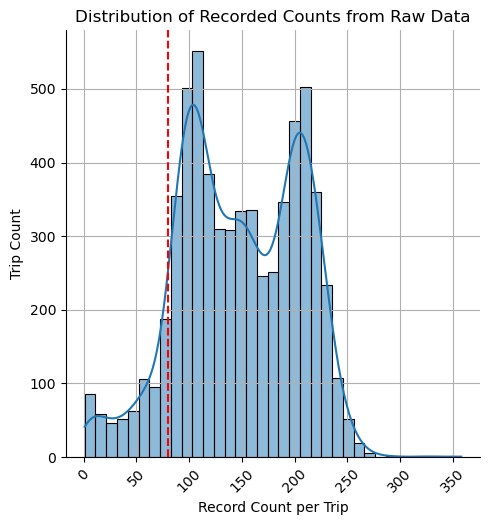

All data trip count: 6356
All data trip count > top percentile 10%: 5987
Trips missing timetable data: 1368
Trips with ambiguous timetable data: 246
Estimated final trip count: 4127


In [17]:
# Load timetable data
dir_path = './data/raw/recorded'
base_path = './data/processed/trips/markers_testing'
csv_files = sorted(glob.glob(os.path.join(dir_path, '*.csv')))

master_dir = './data/processed/timetable/'
service_lookup_table = pd.read_pickle(master_dir+'master_service_lookup_table.pkl')
tracking_data = pd.read_pickle(master_dir+'master_tracking_data.pkl')
timing_data = pd.read_pickle(master_dir+'master_timing_data.pkl')
stop_info = pd.read_pickle(master_dir+'master_stop_info.pkl')

# Processing all the collected data
aggregated_data = pd.DataFrame()
for csv in csv_files:
    print(f'Processing {csv}')
    data = pd.read_csv(csv)
    # print(data.head())
    data['OriginAimedDepartureTime'] = pd.to_datetime(data['OriginAimedDepartureTime'])
    data['DestinationAimedArrivalTime'] = pd.to_datetime(data['DestinationAimedArrivalTime'])
    data['ValidUntilTime'] = pd.to_datetime(data['ValidUntilTime'])
    data['RecordedAtTime'] = pd.to_datetime(data['RecordedAtTime'])
    data['Longitude'] = pd.to_numeric(data['Longitude'])
    data['Latitude'] = pd.to_numeric(data['Latitude'])
    data['BlockRef'] = data['BlockRef'].astype(str).astype(str).str.zfill(4)
    data['DatedVehicleJourneyRef'] = data['DatedVehicleJourneyRef'].astype(str).astype(str).str.zfill(4)
    data.drop_duplicates(subset=unique_idetifier_cols+['RecordedAtTime'],
                        inplace=True)
    data = (data.groupby(unique_idetifier_cols, as_index=False)
            .agg(
                RecordCount = ('ItemIdentifier', 'count')
            ))
    data['TripId'] = data.apply(lambda x: generate_uuid(x[unique_idetifier_cols].to_list()), axis=1).astype(str)
    data['FileName'] = csv
    aggregated_data = pd.concat([aggregated_data[aggregated_data.columns.intersection(std_col_list+['RecordCount', 'FileName'])], 
                                 data[data.columns.intersection(std_col_list+['RecordCount', 'FileName'])]], 
                                 ignore_index=True)

filtered_aggregated_data = aggregated_data[aggregated_data['RecordCount'] >= np.quantile(aggregated_data['RecordCount'], 0.1)]
filtered_aggregated_data = filtered_aggregated_data.merge(service_lookup_table[service_lookup_id_cols+['RouteRef', 'JourneyPatternSectionRefs']], 'left', left_on=siri_id_cols, right_on=service_lookup_id_cols)
dup_check = filtered_aggregated_data.groupby(unique_idetifier_cols+['TripId'], as_index=False).agg(
    count = ('TripId','count')
)
dup_check = dup_check[dup_check['count']>1].reset_index()
missing_data = filtered_aggregated_data[filtered_aggregated_data['RouteRef'].isna()]
collected_trip_data = filtered_aggregated_data[~filtered_aggregated_data['TripId'].isin(dup_check['TripId'])].copy()
collected_trip_data = collected_trip_data[~collected_trip_data['TripId'].isin(missing_data['TripId'])].copy()
removed_sub100_contents = aggregated_data[~aggregated_data['TripId'].isin(filtered_aggregated_data['TripId'])]
removed_dup_contents = dup_check

# Print the filtering result

## Plot the histogram
sns.displot( data=aggregated_data["RecordCount"], kde=True )
## Customize the plot
plt.title('Distribution of Recorded Counts from Raw Data')
plt.xlabel('Record Count per Trip')
plt.ylabel('Trip Count')
plt.xticks(rotation=45)
plt.axvline(x=np.quantile(aggregated_data['RecordCount'], 0.1), color='red', linestyle='dashed', label='Percentile 10%')
plt.grid(True)
plt.show()

print(f"All data trip count: {aggregated_data.shape[0]}")
print(f"All data trip count > top percentile 10%: {filtered_aggregated_data.shape[0]}")
print(f"Trips missing timetable data: {missing_data.shape[0]}")
print(f"Trips with ambiguous timetable data: {dup_check.shape[0]}")
print(f"Estimated final trip count: {collected_trip_data.shape[0]}")

The data is then broken into specific trips by bus line.

For project marking purposes, I would suggest saving the data into a temporary folder defined by the `base_path` variable, in this case `./data/processed/trips/markers_testing`.

In [ ]:
save_col_list = ['RecordedAtTime','ItemIdentifier','ValidUntilTime','LineRef','DirectionRef','DataFrameRef','DatedVehicleJourneyRef','PublishedLineName','OperatorRef','OriginRef','OriginName','DestinationRef','DestinationName','OriginAimedDepartureTime','DestinationAimedArrivalTime','Longitude','Latitude','LongitudeMatched','LatitudeMatched','BlockRef','VehicleRef','TicketMachineServiceCode','JourneyCode','VehicleUniqueId','TripId', 'EstimatedRoute']
for csv in csv_files:
    print(f'PROCESSING {csv}')
    data = pd.read_csv(csv)
    data['OriginAimedDepartureTime'] = pd.to_datetime(data['OriginAimedDepartureTime'])
    data['DestinationAimedArrivalTime'] = pd.to_datetime(data['DestinationAimedArrivalTime'])
    data['ValidUntilTime'] = pd.to_datetime(data['ValidUntilTime'])
    data['RecordedAtTime'] = pd.to_datetime(data['RecordedAtTime'])
    data['Longitude'] = pd.to_numeric(data['Longitude'])
    data['Latitude'] = pd.to_numeric(data['Latitude'])
    data['BlockRef'] = data['BlockRef'].astype(str).astype(str).str.zfill(4)
    data['DatedVehicleJourneyRef'] = data['DatedVehicleJourneyRef'].astype(str).astype(str).str.zfill(4)
    data.drop_duplicates(subset=unique_idetifier_cols+['RecordedAtTime'],
                        inplace=True)
    data['TripId'] = data.apply(lambda x: generate_uuid(x[unique_idetifier_cols].to_list()), axis=1).astype(str)
    for line in bus_list:
        print(f'LINE {line}')
        line_data = data[data['LineRef']==line].copy().reset_index(drop=True)
        for journey in line_data['TripId'].unique().tolist():
            print(f'\t[{csv}/{line}/{journey}] ', end='')
            if journey in collected_trip_data['TripId'].tolist():
                journey_data = line_data[line_data['TripId']==journey].reset_index(drop=True)
                date_string = journey_data['OriginAimedDepartureTime'][0].strftime('%Y%m%d')
                file_link = base_path+str(line)+'_'+str(date_string)+'.pkl'
                journey_data.sort_values(['RecordedAtTime'], ascending=[True], inplace=True)
                journey_data = journey_data[journey_data.columns.intersection(save_col_list)]
                if not os.path.exists(base_path):
                    print('\t\tMADE NEW PATH')
                    os.makedirs(base_path)
                if os.path.exists(file_link):
                    print(f'\t\tUSE OLD FILE {file_link}')
                    buffer_df = pd.read_pickle(file_link)
                    buffer_df = pd.concat([buffer_df, journey_data], ignore_index=True).to_pickle(file_link)
                    buffer_df = pd.DataFrame()
                else:
                    print('\t\tMADE NEW FILE')
                    journey_data.to_pickle(file_link)
            else:
                if journey in removed_dup_contents['TripId'].tolist():
                    print('\t\AMBIGUOUS TIMETABLE DATA')
                elif journey in removed_sub100_contents['TripId'].tolist():
                    print('\t\tJOURNEY TOO SHORT/SPARSE')
                elif journey in missing_data['TripId'].tolist():
                    print('\t\tTIMETABLE DATA MISSING')
                else:
                    print('\t\tWEIRD STUFFS')



### Mass Map-Match and Basic Process Trip

This step involves going through nearly 4,000 trips and map-match all of them to determine the actual path taken by the bus.

Specifically:

1. Decluttering data to eliminate noise at dense area.

2. Map-matching the remaining data points.

3. Calculate basic metrics on each data point, including distance travelled, time taken, and estimating speed.

4. Log all of the process data into a new location `./data/processed/trips_matched/`

For marking purposes, I created a new folder in the `base_path` variable named `./data/processed/trips_matched/marker_testing/` for your tesing of the code.

WARNING: This code requires that a connection to Valhalla at `127.0.0.1` is made. In this project, I used a local Docker server to run Valhalla. Ignore this part if there are considerable difficulty arises. The processed data are alreay available to use on subsequent analysis.

The details set up can be view here: https://medium.com/@hernandezgalaviz/using-valhalla-map-matching-to-get-route-and-travelled-distance-from-raw-gps-points-4ea6b1c88a4c

In [ ]:
trip_path = './data/processed/trips/marker_testing'                # Use this if you want to try to map-match your generated data above
trip_path = './data/processed/trips/'                              # Use this if you want to try to map-match my original processed trip
base_path = './data/processed/trips_matched/marker_testing/'
trip_pkl_files = sorted(glob.glob(os.path.join(trip_path, '*.pkl')))

for line_by_date in trip_pkl_files:
    line_data = pd.read_pickle(line_by_date)

    for trip in line_data['TripId'].unique().tolist():
        trip_data = line_data[line_data['TripId']==trip].copy().reset_index(drop=True)
        trip_data.sort_values(['RecordedAtTime'], ascending=[True], inplace=True)
        print(f'{line_by_date}/{trip}', end='')
        
        # Decluttering trips
        date_string = trip_data['OriginAimedDepartureTime'][0].strftime('%Y%m%d')
        file_link = base_path+'p_'+str(trip_data['LineRef'][0])+'_'+str(date_string)+'.pkl'
        trip_data = decluttering_data(trip_data, w=6, r=50, s=1, lon_col_name='Longitude', lat_col_name='Latitude')
        # Map matching trips
        estimate_route, matched_trip = map_matching(trip_data)
        retry = 0
        while (retry <= 2) and (estimate_route==None):
            time.sleep(0.5)
            estimate_route, matched_trip = map_matching(trip_data)
            retry+=1
        if estimate_route==None:
            estimate_route = LineString([])
        trip_data['EstimatedRoute'] = None
        trip_data['EstimatedRoute'][0] = linestring_to_string(estimate_route)
        
        # Merge new columns to prevous data
        trip_data = pd.concat([trip_data.reset_index(drop=True), matched_trip.reset_index(drop=True)], axis=1)
        
        # Calcuate Distance, Time and Speed
        trip_data['LastTimestamp'] = trip_data['RecordedAtTime'].shift(1)
        trip_data['LastLat'] = trip_data['Latitude'].shift(1)
        trip_data['LastLong'] = trip_data['Longitude'].shift(1)
        trip_data['LastLatMatched'] = trip_data['LatitudeMatched'].shift(1)
        trip_data['LastLongMatched'] = trip_data['LongitudeMatched'].shift(1)
        trip_data['TraveledTime'] = trip_data.apply(lambda x: (x['RecordedAtTime'] - x['LastTimestamp']).total_seconds() if not(pd.isnull(x['LastTimestamp'])) else 0, axis=1)
        
        # Calculate distance based on raw data
        trip_data['TraveledDistanceRaw'] = trip_data.apply(lambda x: geopy.distance.geodesic((x['Latitude'], x['Longitude']), (x['LastLat'], x['LastLong'])).meters if not(pd.isnull(x['LastLat']) or pd.isnull(x['LastLong'])) else 0, axis=1)
        
        # Calculate distance based on mapmatched data
        trip_data['TraveledDistanceMatched'] = trip_data.apply(lambda x: p2p_distance(estimate_route, Point(x['LongitudeMatched'], x['LatitudeMatched']), Point(x['LastLongMatched'], x['LastLatMatched'])) if not(pd.isnull(x['LastLatMatched']) or pd.isnull(x['LastLongMatched'])) else 0, axis=1)

        trip_data['Speed'] = trip_data.apply(lambda x: (x['TraveledDistanceMatched']/1000)/(x['TraveledTime']/60/60) if x['TraveledTime']!=0 else 0, axis=1)
        trip_data['TraveledDistanceMatched'] = trip_data.apply(lambda x: x['TraveledDistanceRaw'] if x['Speed'] > bus_speed_limit*2 else x['TraveledDistanceMatched'], axis=1)
        trip_data['Speed'] = trip_data.apply(lambda x: (x['TraveledDistanceRaw']/1000)/(x['TraveledTime']/60/60) if x['Speed'] > bus_speed_limit*2 else x['Speed'], axis=1)

        # print(journey_data.columns)
        trip_data = trip_data[std_col_list+['LastTimestamp','LastLong','LastLat','LastLongMatched','LastLatMatched','TraveledTime','TraveledDistanceRaw','TraveledDistanceMatched','Speed']]
        if not os.path.exists(base_path):
            print('\tMADE NEW PATH')
            os.makedirs(base_path)
        if os.path.exists(file_link):
            print(f'\tUSE OLD FILE {file_link}')
            buffer_df = pd.read_pickle(file_link)
            buffer_df = pd.concat([buffer_df, trip_data], ignore_index=True).to_pickle(file_link)
            buffer_df = pd.DataFrame()
        else:
            print('\t\tMADE NEW FILE')
            trip_data.to_pickle(file_link)

## Conclusion

With these steps above, the timetable data were extracted and saved in this location `./data/processed/timetable/`, and the map-matched data saved in this location `./data/processed/trips_matched/`, ready to by analyse for insight extraction.